# NDP Song Lyric Generation (using RNN LSTM)

_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

In [1]:
# codes to mount your google drive folder
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Othercomputers/My Computer (1)/CS605_NLP_for_Smart_Assistants/Project/NLP-Lyric-Generator/src/bin

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/My Computer (1)/CS605_NLP_for_Smart_Assistants/Project/NLP-Lyric-Generator/src/bin


## Import dependencies

In [15]:
!pip install rouge

You should consider upgrading via the 'c:\users\teyang\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import re
import sys
import json 

import spacy
import nltk
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split
from gensim import downloader

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.9.4
Tensorflow version: 2.9.1
Keras version: 2.9.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TeYang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
### Custom Imports
sys.path.append('../')
import lib.utilities as utils
from lib.sentiment import Sentiment
from lib.bleu_rouge import bleu_rouge

## Download the dataset

In [18]:
PATH = '../../data'

In [19]:
train_corpus, val_corpus, train_files, val_files = utils.split_corpus(end_song_token = '\n\n\n')

In [20]:
sorted(val_files)

['Because it_s Singapore.txt',
 'Count On Me Singapore.txt',
 'Five Stars Arising.txt',
 'Shine for Singapore.txt',
 'Sing A Song Of Singapore.txt',
 'There_s A Part For Everyone.txt',
 'Together.txt',
 'Voices From The Heart.txt',
 'We Are The Ones.txt',
 'Will You.txt']

## Analyze the dataset

In [5]:
print('Length of Corpus: {} characters'.format(len(train_corpus)))

Length of Corpus: 46038 characters


In [6]:
# Take a look at the first 1000 characters in text.
print(train_corpus[:500])

<VERSE>
One Singapore
One people strong and free
With one heart One voice
We make our history

<VERSE>
We are a rainbow of a thousand colours
Lighting up the sky
We share the Singapore heartbeat
Together you and I, we are

<CHORUS>
One Singapore
One Nation strong and free
A thousand different voices
Sing in harmony
We will stand together
Together hand in hand
As one united people
For Singapore, my homeland

<VERSE>
My Singapore
Our island in the sun
This is my homeland
It's where my strength is 


In [7]:
# clean corpus
def clean_tokenize_corpus(corpus):
  corpus_clean = utils.decontraction(corpus)
  corpus_clean = utils.remove_punct(corpus_clean, '\<|\>')

  # tokenize and count the number of words
  corpus_clean = re.sub('\n\n', '\n', corpus_clean)
  corpus_clean = re.sub('\n', ' \n ', corpus_clean)
  tokens = re.split(' ', corpus_clean)
  tokens_clean = []
  structures = ['<BRIDGE>', '<CHORUS>', '<OTHERS>', '<PRECHORUS>', '<PRELUDE>', '<VERSE>']
  for i,t in enumerate(tokens):
      if t:                                  # remove empty strings
          if i < len(tokens)-1 and t == '\n' and tokens[i+1] in structures:
              tokens_clean.append('\n\n')    # change to double line break for token before structure 
          elif t not in structures:
              tokens_clean.append(t.lower()) # lower case if not structure tokens
          else:
              tokens_clean.append(t)

  return tokens_clean


train_tokens_clean = clean_tokenize_corpus(train_corpus)
val_tokens_clean = clean_tokenize_corpus(val_corpus)

print('Length of Train Corpus: {} words'.format(len(train_tokens_clean)))
# The unique words in the file
vocab = sorted(set(train_tokens_clean))
print('Vocab Size:', len(vocab))
print('Vocab Examples:', train_tokens_clean[:20])
print('')

print('Length of Validation Corpus: {} words'.format(len(val_tokens_clean)))
# The unique words in the file
val_vocab = sorted(set(val_tokens_clean))
print('Vocab Size:', len(val_vocab))
print('Vocab Examples:', val_tokens_clean[:20])



Length of Train Corpus: 11061 words
Vocab Size: 951
Vocab Examples: ['<VERSE>', '\n', 'one', 'singapore', '\n', 'one', 'people', 'strong', 'and', 'free', '\n', 'with', 'one', 'heart', 'one', 'voice', '\n', 'we', 'make', 'our']

Length of Validation Corpus: 2471 words
Vocab Size: 349
Vocab Examples: ['<VERSE>', '\n', 'there', 'is', 'a', 'part', 'for', 'everyone', '\n', 'in', 'this', 'land', 'where', 'we', 'belong', '\n', 'there', 'is', 'a', 'part']


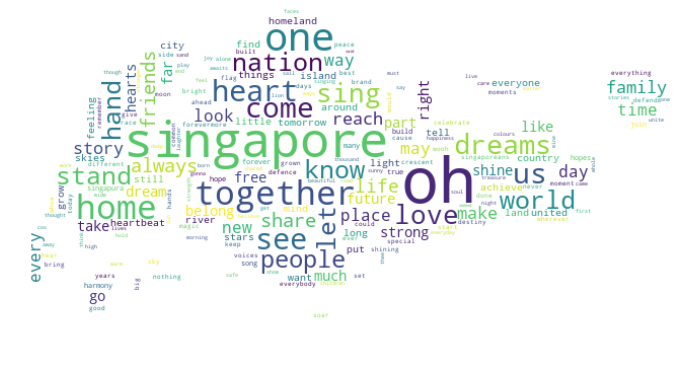

In [8]:
# Unigram Word Cloud

# remove stopwords
stop = set(stopwords.words('english'))
structures = ['<BRIDGE>', '<CHORUS>', '<OTHERS>', '<PRECHORUS>', '<PRELUDE>', '<VERSE>']
stop.update(structures)
stop.update(['\n', '\n\n'])
tokens_no_stopwords = [t for t in train_tokens_clean if t not in stop]

corpus_dict = {}
for word in tokens_no_stopwords:
    corpus_dict[word] = corpus_dict.get(word, 0) + 1

sg_mask = np.array(Image.open("../../images/singaporemap.png"))
my_cloud = WordCloud(background_color='white', stopwords=stop, mask=sg_mask).generate_from_frequencies(corpus_dict)

plt.figure(figsize=(12,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis('off')
plt.show()

## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [9]:
# get word and indices mapping
word_indices = {}
indices_word = {}
word_indices['<OOV>'] = 0
indices_word[0] = '<OOV>'
for i, w in enumerate(sorted(set(train_tokens_clean)), start=1):
# for i, w in enumerate(sorted(set(train_tokens_clean))):
    word_indices[w] = i
    indices_word[i] = w

In [10]:
list(word_indices.items())[:10]

[('<OOV>', 0),
 ('\n', 1),
 ('\n\n', 2),
 ('<BRIDGE>', 3),
 ('<CHORUS>', 4),
 ('<OTHERS>', 5),
 ('<PRECHORUS>', 6),
 ('<PRELUDE>', 7),
 ('<VERSE>', 8),
 ('a', 9)]

In [11]:
list(indices_word.items())[:10]

[(0, '<OOV>'),
 (1, '\n'),
 (2, '\n\n'),
 (3, '<BRIDGE>'),
 (4, '<CHORUS>'),
 (5, '<OTHERS>'),
 (6, '<PRECHORUS>'),
 (7, '<PRELUDE>'),
 (8, '<VERSE>'),
 (9, 'a')]

In [12]:
# convert data to indices numbers (vectorize):
train_tokens_clean = np.array(train_tokens_clean)
train_tokens_clean_idx = np.vectorize(word_indices.get)(train_tokens_clean)

val_tokens_clean = np.array(val_tokens_clean)
val_tokens_clean_idx = np.array([word_indices.get(token, 0) for token in val_tokens_clean])

### Create sequences

In [13]:
word_dataset = tf.data.Dataset.from_tensor_slices(train_tokens_clean_idx)

In [14]:
SEQUENCE_LEN = 15
sequences = word_dataset.window(SEQUENCE_LEN + 1, 1, drop_remainder=True)

for window in sequences.take(3):
    print(repr(' '.join(np.vectorize(indices_word.get)(np.array(list(window.as_numpy_iterator()))))))

'<VERSE> \n one singapore \n one people strong and free \n with one heart one voice'
'\n one singapore \n one people strong and free \n with one heart one voice \n'
'one singapore \n one people strong and free \n with one heart one voice \n we'


In [15]:
sequences = sequences.flat_map(lambda window: window.batch(SEQUENCE_LEN + 1))
for elem in sequences.take(3):
    print(elem)

tf.Tensor([  8   1 538 686   1 538 571 752  37 305   1 916 538 359 538 865], shape=(16,), dtype=int32)
tf.Tensor([  1 538 686   1 538 571 752  37 305   1 916 538 359 538 865   1], shape=(16,), dtype=int32)
tf.Tensor([538 686   1 538 571 752  37 305   1 916 538 359 538 865   1 885], shape=(16,), dtype=int32)


In [17]:
sequences = sequences.map(lambda window: (window[:-1], window[-1:]))
X_train = sequences.map(lambda X,y: X)
y_train = sequences.map(lambda X,y: y)

for elem1, elem2 in zip(X_train.take(3), y_train.take(3)):
    print(elem1, '----->', elem2)

tf.Tensor([  8   1 513 654   1 513 546 720  38 291   1 876 513 346 513], shape=(15,), dtype=int64) -----> tf.Tensor([830], shape=(1,), dtype=int64)
tf.Tensor([  1 513 654   1 513 546 720  38 291   1 876 513 346 513 830], shape=(15,), dtype=int64) -----> tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([513 654   1 513 546 720  38 291   1 876 513 346 513 830   1], shape=(15,), dtype=int64) -----> tf.Tensor([847], shape=(1,), dtype=int64)


In [16]:
def get_sequences(tokens_idx, sequence_len):
  word_dataset = tf.data.Dataset.from_tensor_slices(tokens_idx)
  sequences = word_dataset.window(sequence_len + 1, 1, drop_remainder=True)
  sequences = sequences.flat_map(lambda window: window.batch(sequence_len + 1))
  sequences = sequences.map(lambda window: (window[:-1], window[-1:]))

  return sequences

SEQUENCE_LEN = 15
train_sequences = get_sequences(train_tokens_clean_idx, SEQUENCE_LEN)
val_sequences = get_sequences(val_tokens_clean_idx, SEQUENCE_LEN)

In [54]:
print('train dataset size: {}'.format(len(list(train_sequences.as_numpy_iterator()))))

train dataset size: 11046


In [55]:
dataset_size = len(list(train_sequences.as_numpy_iterator()))
print('train dataset size: {}'.format(dataset_size))

dataset_size = len(list(val_sequences.as_numpy_iterator()))
print('val dataset size: {}'.format(dataset_size))

train dataset size: 11046
val dataset size: 2456


In [17]:
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

print('Batched dataset size: {}'.format(len(list(train_dataset.as_numpy_iterator()))))

Batched dataset size: 172


### Build and Test Model

In [18]:
VOCAB_SIZE = len(word_indices)
EMBEDDINGG_DIM = 128
RNN_UNITS = 512

EPOCHS=5
LR = 0.001

In [19]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    """Build Keras Model

    Args: 
      vocab_size (int): size of vocabulary of corpus
      embedding_dim (int): dimension of word embedding matrix
      rnn_units (int): number of neurons in rnn
      batch_size (int): batch size 

    
    Returns:
      Keras sequential model 
    """
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=False,
#       stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model


model = build_model(VOCAB_SIZE, EMBEDDINGG_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 128)           121856    
                                                                 
 lstm (LSTM)                 (64, 512)                 1312768   
                                                                 
 dense (Dense)               (64, 952)                 488376    
                                                                 
Total params: 1,923,000
Trainable params: 1,923,000
Non-trainable params: 0
_________________________________________________________________


In [20]:
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 952) # (batch_size, sequence_length, vocab_size)


In [21]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    """Compute the loss from outputed logits of model

    Args: 
      labels (list): y labels / ground truth
      logits (list): logits outputed by the model
    
    Returns:
      Loss score
    """
    
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 952)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       6.8583493


In [22]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [23]:
# # Directory where the checkpoints will be saved.
# checkpoint_dir = 'tmp/checkpoints'
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Name of the checkpoint files
# checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_prefix,
#     save_weights_only=True
# )

### Train Model

In [29]:
history = model.fit(
  x=train_dataset,
  epochs=EPOCHS,
  validation_data=val_dataset,
  # shuffle=True,
  # callbacks=[
  #   checkpoint_callback
  # ]
)

Epoch 1/5
172/172 [==============================] - 19s 108ms/step - loss: 2.9431 - val_loss: 5.0730
Epoch 2/5
172/172 [==============================] - 19s 109ms/step - loss: 2.5363 - val_loss: 5.2008
Epoch 3/5
172/172 [==============================] - 19s 108ms/step - loss: 2.1586 - val_loss: 5.3559
Epoch 4/5
172/172 [==============================] - 19s 109ms/step - loss: 1.8270 - val_loss: 5.4687
Epoch 5/5
172/172 [==============================] - 19s 108ms/step - loss: 1.5069 - val_loss: 5.5302


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of words to generate.

- Get the prediction distribution of the next word using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted word as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one word. After predicting the next word, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted words.

In [30]:
# num_generate
# - number of words to generate.
#
# temperature

# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    """Generate text using trained sequential text generation model

    Args: 
      model (model): Keras trained sequential text generation model
      start_string (list): list of strings for starting the text generation
      num_generate (int): number of words to generate
      temperature (float): controls the predictability of the generated text
        - Low temperatures results in more predictable text.
        - Higher temperatures results in more surprising text.
    
    Returns:
      String of generated text
      
    """

    # Converting our start string to numbers (vectorizing).
    input_indices = [word_indices.get(s, 0) for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for word_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predictions = tf.reshape(predictions, [1, predictions.shape[0]])
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
            )[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(indices_word[predicted_id])
    
    return (' '.join(start_string) + '\n ' + ' '.join(text_generated))

In [31]:
NUM_GENERATE = 100

In [37]:
# clean val set for sampling prompts and references
val_clean_corpus = []
for i,file in enumerate(val_files):
    text = open(PATH + '/' + file, mode='r').read()
    val_clean_corpus.append(text)

for i,song in enumerate(val_clean_corpus):
    song = re.sub(r'<[A-Z]+>|', '', song)
    # val_clean_corpus = re.sub(r'\n', '<break>')
    song = [sent for sent in song.split('\n') if sent]
    song = [utils.preprocess_text(sent) for sent in song]
    song.append('')
    val_clean_corpus[i] = song

val_clean_corpus = [sent for song in val_clean_corpus for sent in song ]

from lib.bleu_rouge import bleu_rouge
br = bleu_rouge()
prompt_ref = br.get_prompt_reference(val_clean_corpus, 100)

In [34]:
# with open('../../output/prompt_ref.json', 'w') as f:
#     json.dump(dict(sorted(prompt_ref.items())), f)

In [35]:
with open('../../output/prompt_ref.json') as f:
    prompt_ref = json.load(f)

In [34]:
# use sampled prompts to generate lyrics
generated_results = {}
for prompt in sorted(prompt_ref):
  g_text = generate_text(model, start_string=prompt.split(' '), num_generate=NUM_GENERATE)
  g_text = re.sub(r'<[A-Z]+>|', '', g_text)
  g_text = re.sub(r'\s+', ' ', g_text).strip()
  generated_results[prompt] = g_text
  

  # save to file
  filename = f'../../output/br_LSTM_{prompt}.txt'
  with open(filename, 'w') as f:
    f.write(g_text)
  f.close()

In [35]:
print(list(generated_results.items())[0][1])

and we will do what must be done
 
 our walking wo teach was really darkest amazed used enemies let high face whenever i the renewed wide so no birds wide raffles care is universe think sun every taken any sunsets based give youre see grows singaporean as it bursts wake cross smile broadway stars town weak recognition way said united who forget million bell dedicated bloom show bravely given climb all highest time gather wide in different never wanna stay turn sky turn a flame lions fire again crystals sunny knew be he red do better expect snow done x sing comes five peace families have downstairs


In [36]:
print(list(generated_results.items())[1][1])

deep inside your heart where it belongs
 
 singapura 

 carry sunny sea a time breathe let birds downs divine each blessing international walk high by <PRELUDE> give a time defending spot tame oh story grow sand see another top spain build a to put oh oh oh oh oh 

 land bang hardly deep calling fine got religion home escape taken nation heed sweet fine begin grateful <OTHERS> calling ben remember little forever beautiful courage closest across downs whoa oh oh oh oh in each land price road sister not dividing there worthwhile bang wonderful could heartaches to go great chorus everybody remain much walked than


In [ ]:
# generate lyrics for 6 standard prompts
prompts = [
    'whenever I think back', 
    'and so this I know',
    'i am tired of being what you want me to be', 
    'feeling so faithless, lost under the surface',
    'relight our fire, we will find our way', 
    'we will rise stronger together'
]

generated_results_standard = {}
for prompt in prompts:
  g_text = generate_text(model, start_string=prompt.split(' '), num_generate=NUM_GENERATE)
  g_text = re.sub(r'<[A-Z]+>|', '', g_text)
  g_text = re.sub(r'\s+', ' ', g_text).strip()
  generated_results_standard[prompt] = g_text

  # save to file
  filename = f'../../output/human_LSTM_{prompt}.txt'
  with open(filename, 'w') as f:
    f.write(g_text)
  f.close()


### Evaluate Bleu and Rouge Score

In [66]:
bleu_scores = {}
rouge_scores = {}

for prompt, generated in generated_results.items():
  # clean generated
  generated = re.sub(prompt, '', generated) # remove prompt as sometimes there is not next line token between it and next line
  generated = re.sub(r'<[A-Z]+>|', '', generated) # remove structure tokens
  generated = re.sub(r'\s+', ' ', generated).strip() # remove consec spaces
  ref = generated.split('\n')[1] # take line after prompt
  
  
  # get bleu
  bleu_scores[prompt] = br.compute_bleu(prompt, ref, verbose=False)
# get rouge
  rouge_scores[prompt] = br.compute_rouge(prompt, ref, verbose=False)

In [75]:
# average the each bleu score over the number of prompts sampled
bleu_avg = {}

for _,value in bleu_scores.items():
    for key,val in value.items():
        bleu_avg.setdefault(key, []).append(val)

bleu_avg = {i:sum(bleu_avg[i])/len(bleu_avg[i]) for i in bleu_avg}
bleu_avg

{'BLEU-1': 0.0, 'BLEU-2': 0.0, 'BLEU-3': 0.0, 'BLEU-4': 0.0, 'Avg': 0.0}

In [77]:
# average the each rouge score over the number of prompts sampled
rouge_avg = {}

for _,value in rouge_scores.items():
    for key,val in value.items():
        rouge_avg.setdefault(key, []).append(val['r'])

rouge_avg = {i:sum(rouge_avg[i])/len(rouge_avg[i]) for i in rouge_avg}
rouge_avg

{'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-l': 0.0}

### Evaluate sentiment of generated text

In [82]:
generated_texts = []
for prompt, generated in generated_results.items():
  generated = re.sub(prompt, '', generated)
  generated = re.sub(r'<[A-Z]+>|', '', generated)
  generated = re.sub(r'\n', ' ', generated)
  generated = re.sub(r'\s+', ' ', generated)
  generated = generated.strip()

  generated_texts.append(generated)

In [84]:
clean_corpus = re.sub(r'<[A-Z]+>|', '', val_corpus)
clean_corpus = re.sub(r'\n', ' ', clean_corpus)
clean_corpus = re.sub('\s+', ' ', clean_corpus)
clean_corpus = clean_corpus.strip()

clean_corpus[:500]

"There's a part for everyone In this land where we belong There's a part for one and all To keep the peace we want Though not all will carry arms To help defend our land We must all do what we can Together hand in hand Put your heart, your mind, your skill to our defence Put your heart, your mind, your skill to our defence Put your art, your work and will To the defence of Singapore Put your heart, your mind, your skill to our defence We have sailors We have airmen We have soldiers brave and good"

In [85]:
print(list(downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [86]:
glove_vectors = downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [118]:
SENTIMENT_THEMES = [
    'unity', 'affection', 'aspiration', 'home', 
    'relationship', 'motivation', 'nationhood', 
    'life', 'celebrate'
]
wv_scores = {}
vader_scores = {}

for i,gt in enumerate(generated_texts):
  # create Sentiment object
  sentiment = Sentiment()

  # clean and tokenize text
  sentiment.clean_text(
      original_text = clean_corpus, 
      generated_text = gt, 
      remove_stopwords=True, 
      stop_words = set(stopwords.words("english"))
  )

  # this step scores the vader sentiment of the original and generated text 
  sentiment.score_vader_sentiment()  

  # this step extracts the top n similar word vectors to each theme
  # and get their average word vector
  sentiment.get_theme_vector(
      sentiment_themes=SENTIMENT_THEMES, 
      embedding=glove_vectors, 
      topn=10
  )

  sentiment.score_word_vector_sentiment()  

  vader_scores[i] = sentiment.vader_sentiment_scores
  wv_scores[i] = sentiment.word_vector_sentiment_scores
  

In [102]:
# average the vader scores over the number of prompts sampled
vader_avg = {}

for _,value in vader_scores.items():
    for key, val in value.items():
        vader_avg.setdefault(key, []).append(val['compound'])

vader_avg = {i:sum(vader_avg[i])/len(vader_avg[i]) for i in vader_avg}
vader_avg

{'original': 1.0, 'generated': 0.9614100000000001}

In [201]:
# average the word vector scores over the number of prompts sampled

tmp = {theme: [] for theme in SENTIMENT_THEMES}
wv_avg = {}
wv_avg['original'] = tmp.copy()
wv_avg['generated'] = tmp.copy()


for og in ['original', 'generated']:
    for theme in SENTIMENT_THEMES:
        for i in wv_scores.keys():
            wv_avg[og][theme] = wv_avg[og][theme] + [wv_scores[i][og][theme]]

for key, val in wv_avg.items():
    for k,v in val.items():
        wv_avg[key][k] = np.mean(wv_avg[key][k])

wv_avg

{'original': {'unity': 0.65909183,
  'affection': 0.42029563,
  'aspiration': 0.4368441,
  'home': 0.9099243,
  'relationship': 0.69015455,
  'motivation': 0.7421752,
  'nationhood': 0.07974253,
  'life': 0.95756847,
  'celebrate': 0.49134722},
 'generated': {'unity': 0.6036158,
  'affection': 0.3964491,
  'aspiration': 0.38609734,
  'home': 0.91817474,
  'relationship': 0.64420307,
  'motivation': 0.71559095,
  'nationhood': 0.050876122,
  'life': 0.94248116,
  'celebrate': 0.49041134}}

In [202]:
wv_avg_theme = {}
wv_avg_theme['original'] = np.mean(list(wv_avg['original'].values()))
wv_avg_theme['generated'] = np.mean(list(wv_avg['generated'].values()))
wv_avg_theme

{'original': 0.59857154, 'generated': 0.5719888}

## Save the model

In [ ]:
# model_name = '../../models/text_generation_lstm_word_level.h5'
# model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.h5 \
  ./demos/public/models/text_generation_shakespeare_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.